## Scraping

In [1]:
import requests
from bs4 import BeautifulSoup

# For each column, create empty list with size of 1000
change = [None]*1000
name = [None]*1000
score = [None]*1000
province = [None]*1000
city = [None]*1000

sch_type = [None]*1000

# Scrap for 10 pages
for n_page in range(1,11):

    page = requests.get("https://top-1000-sekolah.ltmpt.ac.id/?page={}&per-page=100".format(n_page))
    soup = BeautifulSoup(page.content, "html.parser")

    # Table for each school's score starts from the 9th row
    rows = soup.find_all('td')[8:]

    # Each row consists of 8 elements, so in each iterates there are 8 elements
    for n in range(int(len(rows)/8)):
        start = n * 8;
        finish = start + 7;

        # Here is the 8 elements
        row = rows[start:finish + 1]

        # Index in the columns for each page.
        # Page 1: 0-99, page 2: 100-199, ...
        n_index = n + (100 * (n_page - 1))

        # change_sign is the type of change: ↑, ↓, or =
        change_sign = row[1].i['class'][1]

        # Get the text from each tag
        for i in range(0, 8):
            row[i] = row[i].get_text()

        # downvote sign means that the rank of that particular school is decreasing from last year 
        if change_sign == "bxs-downvote":
            row[1] = -int(row[1])
            
        # Get rid of " More.." in "name" column
        row[3] = row[3][:-7]

        # We don't need NPSN number in row[2] and "rank" in row[0]
        indexes = list(range(8))
        indexes.remove(2)
        indexes.remove(0)

        # Assign each information to the corresponding column
        change[n_index], name[n_index], score[n_index], province[n_index], city[n_index], sch_type[n_index] = (row[i] for i in indexes)


## Create dataframe and convert data type

In [2]:
import pandas as pd
ltmpt = pd.DataFrame({
    "change": change,
    "name":name,
    "score":score,
    "province":province,
    "city":city,
    "sch_type":sch_type,
})
ltmpt

,change,name,score,province,city,sch_type
0,1,MAN INSAN CENDEKIA SERPONG,"637,807",Banten,Kota Tangerang Selatan,MA
1,-1,SMAN UNGGULAN M.H. THAMRIN,"635,675",DKI Jakarta,Kota Jakarta Timur,SMA
2,1,SMAN 8 JAKARTA,"630,860",DKI Jakarta,Kota Jakarta Selatan,SMA
3,-1,SMAS UNGGUL DEL,"630,177",Sumatera Utara,Kab. Toba Samosir,SMA
4,2,SMAS BPK 1 PENABUR BANDUNG,"618,415",Jawa Barat,Kota Bandung,SMA
...,...,...,...,...,...,...
995,5,SMAN 1 NGAWEN,"512,127",Jawa Tengah,Kab. Blora,SMA
996,4,SMAN 2 BREBES,"512,108",Jawa Tengah,Kab. Brebes,SMA
997,3,SMAN 1 SAWAHLUNTO,"512,083",Sumatera Barat,Kota Sawah Lunto,SMA
998,2,SMAN 1 PARUNG,"512,076",Jawa Barat,Kab. Bogor,SMA


In [3]:
ltmpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   change    1000 non-null   object
 1   name      1000 non-null   object
 2   score     1000 non-null   object
 3   province  1000 non-null   object
 4   city      1000 non-null   object
 5   sch_type  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [4]:
# Convert some columns to numeric value
ltmpt['change'] = pd.to_numeric(ltmpt['change']).fillna(0)

ltmpt['score'] = ltmpt['score'].str.replace(",", ".")
ltmpt['score'] = pd.to_numeric(ltmpt['score']).fillna(0)

In [5]:
# Remove "Kab. " and "Kota " in city column

# Safe to remove the first 5 letter, because every city starts with either Kab. or Kota
print(ltmpt['city'].str[:5].unique())

ltmpt['city'] = ltmpt['city'].str[5:]

['Kota ' 'Kab. ']


In [6]:
ltmpt.head(7)

,change,name,score,province,city,sch_type
0,1.0,MAN INSAN CENDEKIA SERPONG,637.807,Banten,Tangerang Selatan,MA
1,-1.0,SMAN UNGGULAN M.H. THAMRIN,635.675,DKI Jakarta,Jakarta Timur,SMA
2,1.0,SMAN 8 JAKARTA,630.860,DKI Jakarta,Jakarta Selatan,SMA
3,-1.0,SMAS UNGGUL DEL,630.177,Sumatera Utara,Toba Samosir,SMA
4,2.0,SMAS BPK 1 PENABUR BANDUNG,618.415,Jawa Barat,Bandung,SMA
5,0.0,SMAS 1 KRISTEN BPK PENABUR,617.214,DKI Jakarta,Jakarta Barat,SMA
6,5.0,SMAN 3 YOGYAKARTA,616.584,DI Yogyakarta,Yogyakarta,SMA


## Visualization and Insight

### What type of school that dominates the top 1000?

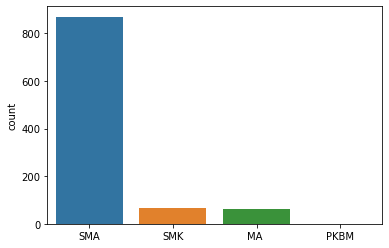

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=ltmpt, x=sch_type, order=ltmpt['sch_type'].value_counts().index)
plt.show()

In the top 1000 UTBK score, SMA is dominating for over 80% of the data. This seems okay, because SMA itself is the most common high-school type in Indonesia. Also, SMK and MA have different purpose than SMA that generally wants their students to continue their education. In SMK, for example, students are prepared to get employed as soon as they are graduated.

### What province dominates the top 1000? A picture of how education is unequally distributed in Indonesia

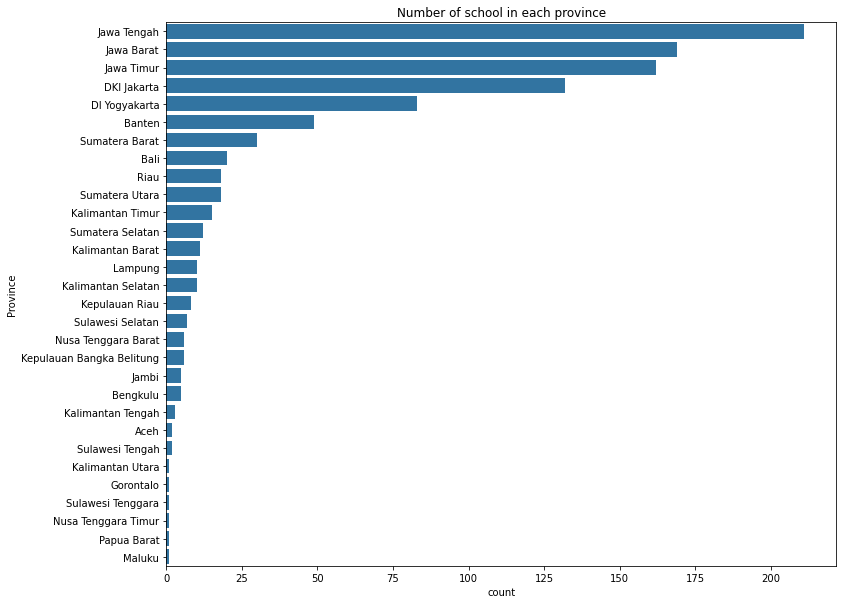

In [8]:
plt.figure(figsize=(12, 10))
sns.countplot(data=ltmpt, y='province', orientation='horizontal', order=ltmpt['province'].value_counts().index, color="tab:blue")
plt.title("Number of school in each province")
plt.ylabel("Province")
plt.show()

Notice that there are only 6 provinces in Java island, and they dominate the top 1000 UTBK out of 30 provinces included.
This suggests a extreme unequally distributed education in Indonesia, with most people received better education in Java island.

Also notice that there are 34 provinces in Indonesia, but there are only 30 provinces included in this data:

In [9]:
print("Number of provinces in this data:", len(ltmpt['province'].unique()))

Number of provinces in this data: 30


Which means that all school from 4 provinces don't make it to the top 1000. These provinces are **Sulawesi Barat, Sulawesi Utara, Maluku Utara, and Papua**. These provinces come from the east side of Indonesia. You probably have heard of this issue before, that education in the "eastern" is rarely get attention.

### What province has the highest average score?

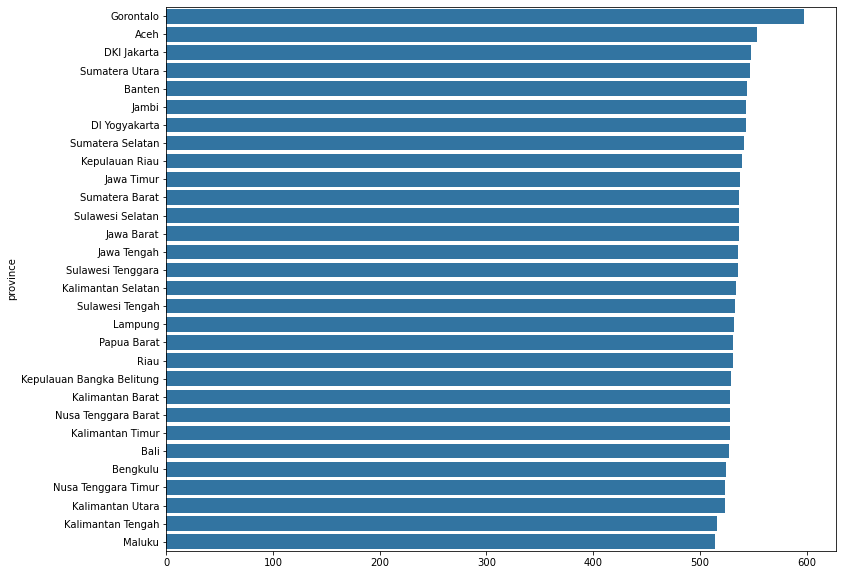

In [10]:
ltmpt_province = ltmpt.groupby("province")["score"].agg("mean").sort_values(ascending=False)

plt.figure(figsize=(12, 10))

sns.barplot(x=ltmpt_province.values, y=ltmpt_province.index, color='tab:blue')
plt.title
plt.show()

**Whoah!** Why Gorontalo is far beyond other provinces, even DKI Jakarta? Is there something wrong?

**Here is why:**

In [11]:
ltmpt[ltmpt['province'] == "Gorontalo"]

,change,name,score,province,city,sch_type
24,11.0,MAN Insan Cendekia Gorontalo,597.665,Gorontalo,Bone Bolango,MA


There are only a school in Gorontalo which makes it to the top 1000!

That is why Gorontalo is #1 in term of average score of provinces. They averaged their only school, and that is an exceptional school, which is an **outlier!**

So, how can we resolve this?

Well, there are some options, but I will simply choose province that have at least 10 school in the top 1000.

Here is the result:

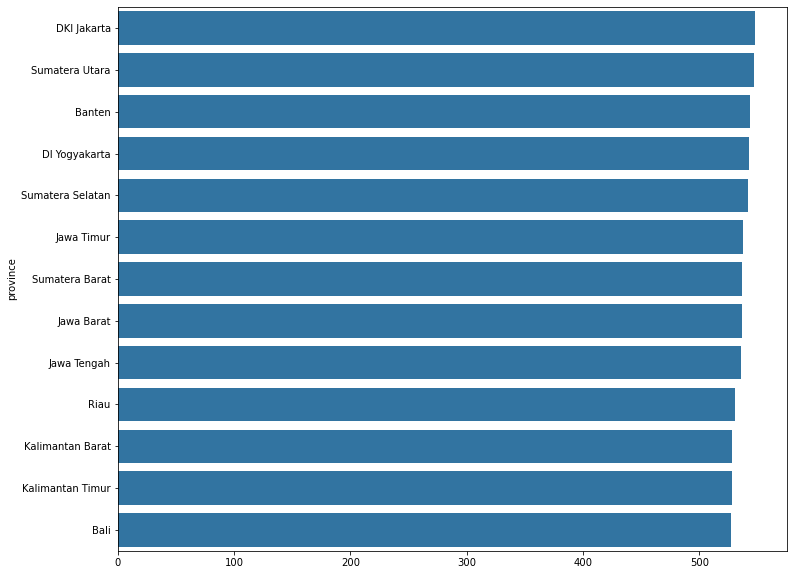

In [12]:
prov_count = ltmpt['province'].value_counts()
prov_list = prov_count[prov_count.values > 10].index

ltmpt_filtered = ltmpt[ltmpt['province'].isin(prov_list)]
ltmpt_province = ltmpt_filtered.groupby("province")["score"].agg("mean").sort_values(ascending=False)

plt.figure(figsize=(12, 10))

sns.barplot(x=ltmpt_province.values, y=ltmpt_province.index, color='tab:blue')
plt.title
plt.show()

Well, in terms of average score, there is no big difference between provinces.

Don't forget that the score data comes from top 1000 school. Therefore only school with high score will be calculated here, which makes the average score is high and less difference between provinces.

## Tableau visualization

Next, I will visualize score in every city using tableau. I will import the dataframe into csv, so I can import it into tableau.

In [13]:
ltmpt.to_csv("ltmpt.csv")

### Number of school

You can see that schools listed in top 1000 are centralized in Java island.

![alt text](count-province.jpg "School Count by Province")

### Average score

This shows average score of each province. we can see that Gorontalo has the hightest average score, and no other province comes close to it.

We already discussed before that Gorontalo is an outlier, and that we will choose only province with more than 10 school listed in top 1000. We will do it in the next section.

![alt text](average-score-all.jpg "Average Score")

#### Average score of province with 10 school or more

![alt text](average-score-10.jpg "Average Score with Filter")